In [1]:
from skimage import data, io, filters, restoration
from skimage.util import view_as_windows as viewW
from skimage.util import random_noise
from skimage.morphology import disk
from matplotlib import pyplot as plt
import cv2 as cv
import scipy
import numpy
import math
import os
import random
from deap import base, creator, tools, algorithms

In [2]:
import importlib
from util import performance_functions
from util.weak_texture_patches import noise_level, weak_texture_mask
importlib.reload(performance_functions)

<module 'util.performance_functions' from '/home/sam/Documents/Notes/UCC/FYP/util/performance_functions.py'>

## Resources

- Source code: https://uk.mathworks.com/matlabcentral/fileexchange/36921-noise-level-estimation-from-a-single-image
- MATLAB to python: https://cheatsheets.quantecon.org/, http://mathesaurus.sourceforge.net/matlab-numpy.html



In [3]:
test_image = cv.imread('images/42078.jpg')
test_image = test_image[:,:,::-1]


In [4]:
def add_gaussian_noise(img, sig = 1):
    m = (0,0,0) 
    s = (sig,sig,sig)  
    noise = numpy.zeros(img.shape)
    cv.randn(noise,m,s)
    print(noise.min(), noise.max())
    new_img = (img+noise) 
    #new_img = (new_img - new_img.min()) * (255/new_img.max())
    return new_img

[0.13994551450950854, 0.14116239518011633, 0.16288527404448924] [6.885422392394682, 7.0200745027640465, 9.112892926465541] [14746, 22057, 20132]


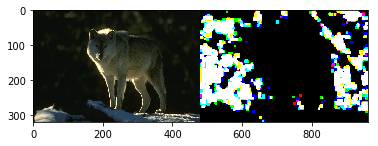

[0.009374972713587766, 0.009465051144412881, 0.009574635666077368] [0.004862002223908324, 0.004914919209797353, 0.004917736246535665] [67702, 72572, 75366]


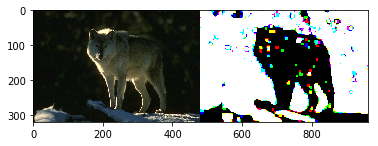

In [5]:
nlevel, th, num = noise_level(test_image)
print(nlevel, th, num)
msk1 = weak_texture_mask(test_image, th )
disp1 = numpy.hstack((test_image,msk1.astype(numpy.uint8) * 255))
plt.imshow(disp1)
plt.show()

noisy_image = random_noise(test_image, mode="gaussian", var=0.0001)
nlevel, th, num = noise_level(noisy_image, conf=0.97)
print(nlevel, th, num)
msk2 = weak_texture_mask(noisy_image, th)
disp2 = numpy.hstack((noisy_image* 255,msk2 * 255)).astype(numpy.uint8)
plt.imshow(disp2)
plt.show()

/home/sam/Documents/Notes/UCC/FYP/env/lib/python3.6/site-packages/skimage/filters/_gaussian.py:108: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


Fitness when applying no denoising algorithm:  50530259.00361992
-------------
Fitness after applying denoising algorithm:  53754838


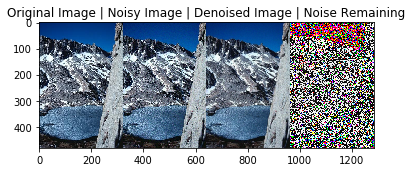


Testing fitness funtion with optional display parameter:


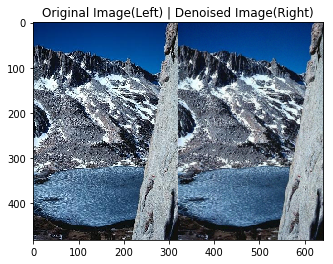

Result:  13.348443035449906


In [6]:
def evaluate_fitness(denoised_image, original_image, display_images=False):
    
    if display_images:
        
        merged_images = numpy.hstack((original_image,denoised_image))
        plt.title("Original Image(Left) | Denoised Image(Right)")
        plt.imshow(merged_images)
        plt.show()
        
    return performance_functions.root_mean_squared_error(denoised_image, original_image)

fitness_test_image = cv.imread('images/167083.jpg')

noisy_test_images = random_noise(fitness_test_image, mode="gaussian", var=0.0002)

denoised_test_image = filters.gaussian(noisy_test_images,sigma=0.61)
denoised_test_image *= 255
denoised_test_image = denoised_test_image.astype(numpy.uint8)

baseline = fitness_test_image - noisy_test_images

test_fitness = fitness_test_image - denoised_test_image

print("Fitness when applying no denoising algorithm: ",numpy.absolute(baseline).sum())
print("-------------")
print("Fitness after applying denoising algorithm: ", numpy.absolute(test_fitness).sum())

all_images_merged = numpy.hstack((fitness_test_image,noisy_test_images*255,denoised_test_image,test_fitness)).astype(numpy.uint8)
rgb_all_images = cv.cvtColor(all_images_merged, cv.COLOR_BGR2RGB)
plt.imshow(rgb_all_images)
plt.title("Original Image | Noisy Image | Denoised Image | Noise Remaining")
plt.show()

denoised_test_image =  cv.cvtColor(denoised_test_image, cv.COLOR_BGR2RGB)
fitness_test_image =  cv.cvtColor(fitness_test_image, cv.COLOR_BGR2RGB)
print("\nTesting fitness funtion with optional display parameter:")
print("Result: ", evaluate_fitness(denoised_test_image, fitness_test_image, display_images=True))

In [7]:
import sys
class ImageDataset:
    
    def __init__(self, size, sigma=0.0002):
        self.dir_location = "images/"
        self.base_images = []
        self.noisy_images = []
        self.weak_texture_masks = []
        self.noise_levels = []
        self.sigma = sigma
        self.load_files(size)
        
        
    def load_files(self, size):
        self.base_images = []
        for image_name in os.listdir(self.dir_location):
            if len(self.base_images) >= size:
                break
            new_image = cv.imread(self.dir_location+image_name);
            new_image = new_image[:,:,::-1]
            self.base_images += [new_image]
            noisy_image = random_noise(new_image, mode="gaussian", var=self.sigma)
            
            self.noisy_images += [noisy_image]
            try:
                nlevel, th, num = noise_level(noisy_image, conf=0.97)
                self.noise_levels += [nlevel]
                new_image_mask = weak_texture_mask(noisy_image,th)
                self.weak_texture_masks += [new_image_mask]
            except Exception as e:
                print(e)
                plt.imshow(new_image)
                plt.show()
            
            
            
        

In [21]:
images = ImageDataset(2,0.0005)

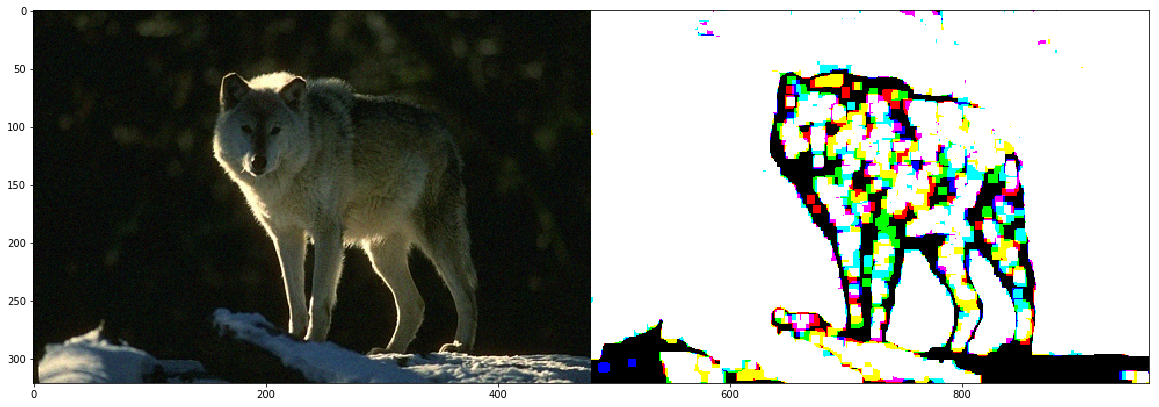

In [22]:
img_and_mask = numpy.hstack((images.noisy_images[1]*255,images.weak_texture_masks[1]*255)).astype(numpy.uint8)
plt.imshow(img_and_mask)
plt.show()

## Sensors

| Sensor ID | Sensor Data |
| --- | --- |
| 0 | weak texture mask |
| 1 | non weak texture mask |

## Actions

| Action ID | Action |
| --- | --- |
| 0 | gaussian_filter_coins sigma 1 | 
| 1 | gaussian_filter_coins sigma 2 |
| 2 | median_filter one(3, 3) |
| 3 | tv_chambolle weight 0.1 |

In [36]:
def denoise_image(image, action_id):
    
    psf = numpy.ones((5, 5, 3)) / 25
    actions = [
        lambda x : (filters.gaussian(x ,sigma=0.01)*255).astype(numpy.uint8),
        lambda x : (filters.gaussian(x, sigma=0.02)*255).astype(numpy.uint8),
        lambda x : (filters.gaussian(x, sigma=0.025)*255).astype(numpy.uint8),
        lambda x : (filters.gaussian(x, sigma=0.4)*255).astype(numpy.uint8),
        lambda x : (restoration.denoise_tv_chambolle(x, weight=0.02)*255).astype(numpy.uint8),
        lambda x : (restoration.denoise_tv_chambolle(x, weight=0.01)*255).astype(numpy.uint8),
        lambda x : (restoration.denoise_tv_chambolle(x, weight=0.005)*255).astype(numpy.uint8),
        lambda x : (restoration.denoise_tv_chambolle(x, weight=0.001)*255).astype(numpy.uint8),
    ]
    if action_id > len(actions):
        return image
    return actions[action_id](image)

In [37]:
def bits_to_int(bit_list):
    return sum([(x*(2**i)) for i, x in enumerate(bit_list[::-1])])

In [38]:
def extract_weak_texture(image, weak_texture_mask):
    weak_texture = (image * weak_texture_mask).astype(numpy.uint8)
    strong_texture = image - weak_texture
    return strong_texture.astype(numpy.uint8), weak_texture.astype(numpy.uint8)

In [39]:
def excecute_actions(individual, image_index = 0):
    weak_texture_action = bits_to_int(individual[0:len(individual)//2])
    strong_texture_action = bits_to_int(individual[len(individual)//2:len(individual)])
    
    
    denoised_weak_texture = denoise_image(images.noisy_images[image_index], weak_texture_action)
    denoised_strong_texture = denoise_image(images.noisy_images[image_index], strong_texture_action)
    
    strong_texture, _ = extract_weak_texture(denoised_strong_texture, images.weak_texture_masks[image_index])
    _, weak_texture = extract_weak_texture(denoised_weak_texture, images.weak_texture_masks[image_index])
    
    return (strong_texture + weak_texture ) 
    

In [40]:
import importlib
from util import performance_functions
importlib.reload(performance_functions)

def evaluate(individual, display=False, image_index = 0): 
    
    denoised_image = excecute_actions(individual, image_index)
    
    if display:
        print("PSNR: %f\n IQI: %f\n SSIM: %f\n" % \
              (performance_functions.peak_signal_noise_ration(images.base_images[image_index], denoised_image),\
               performance_functions.image_quality_index(images.base_images[image_index], denoised_image),\
               performance_functions.structural_similarity_indix(images.base_images[image_index], denoised_image),))
        plt.rcParams["figure.figsize"]=20,20
        merged_images = numpy.hstack((images.base_images[image_index],\
                                      images.noisy_images[image_index]*255,\
                                      denoised_image))\
                             .astype(numpy.uint8)
        plt.title("Original Image(Left) | Noisy Image(Center) | Denoised Image(Right)")
        plt.imshow(merged_images)
        plt.show()
        
                                                   
                                                   
    return performance_functions.root_mean_squared_error(denoised_image, images.base_images[image_index]),
    
    

PSNR: 33.290226
 IQI: 0.999626
 SSIM: 0.925455



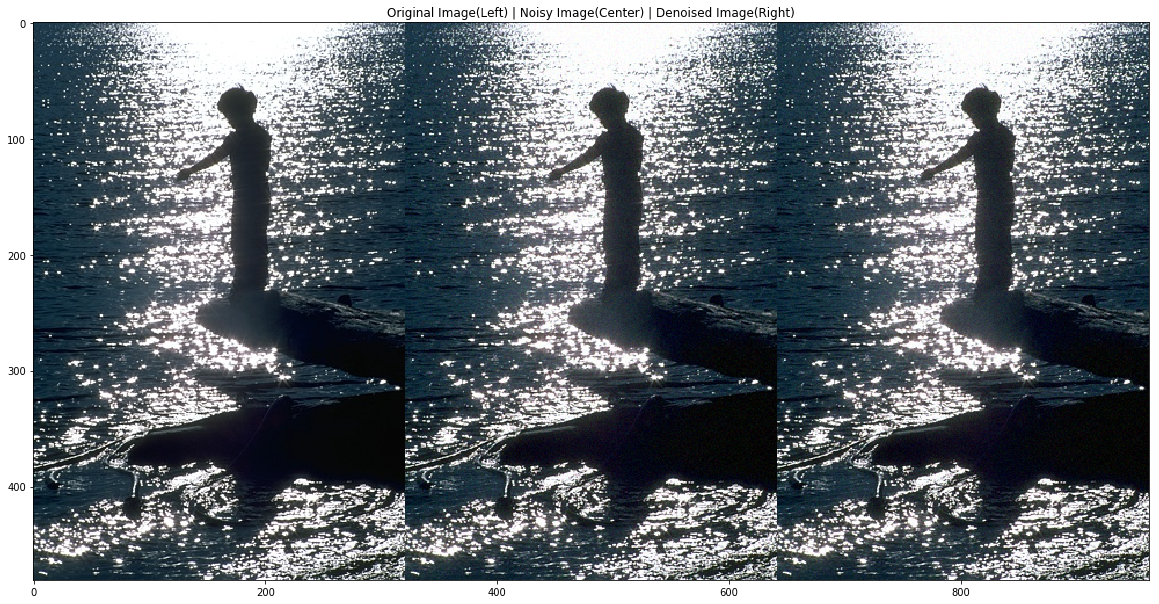

(9.325897499363043,)

In [41]:
evaluate([0,0,1,0,0,1], True)

[1, 0, 1, 1, 1, 0]
PSNR: 34.572995
 IQI: 0.999710
 SSIM: 0.967497



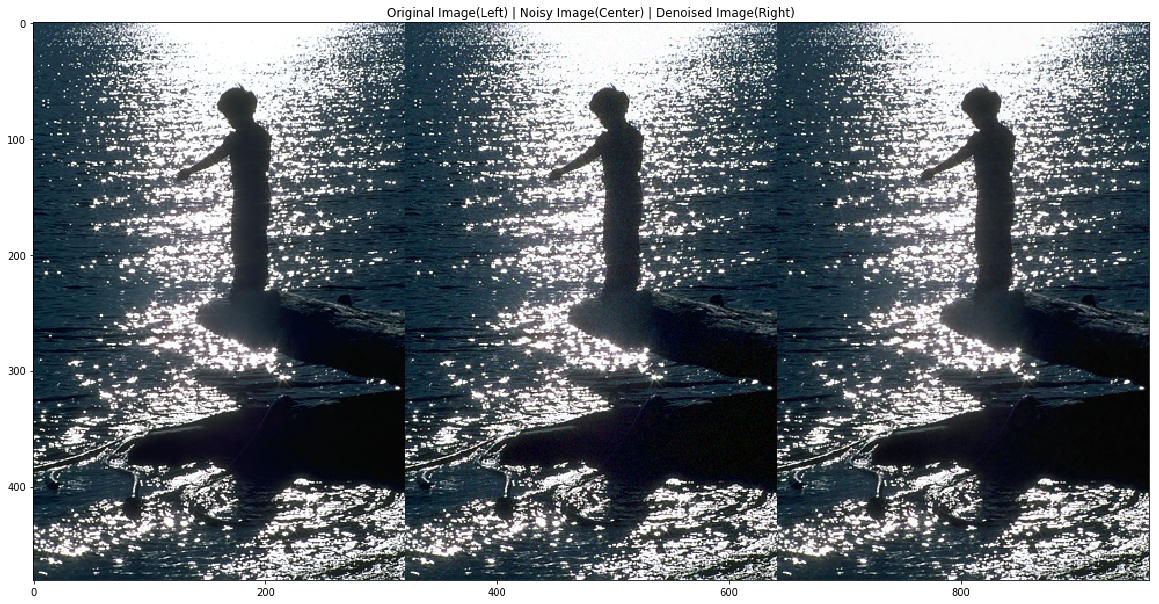

(8.12877211085457,)


In [42]:
import random
from deap import algorithms, base, creator, tools

NUM_FILTERS = 8
SIZE_OF_INDIVIDUAL = math.ceil(math.log2(NUM_FILTERS**2))

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)


toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=SIZE_OF_INDIVIDUAL)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)


pop = toolbox.population(n=20)
algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=20, verbose=False)
print(tools.selBest(pop, k=1)[0])
print(evaluate(tools.selBest(pop, k=1)[0], True))

In [43]:
def compare_results(individual):
    test_image_rmse = evaluate(individual, True)
    new_image_rmse = evaluate(individual, True, 1)
    print("Test Image RMSE: %f \nUnseen Image RMSE: %f"%(test_image_rmse[0], new_image_rmse[0]))
    print("Test Image Estimated Noise:", images.noise_levels[0])
    print("Unseen Image Estimated Noise:", images.noise_levels[1])

PSNR: 34.572995
 IQI: 0.999710
 SSIM: 0.967497



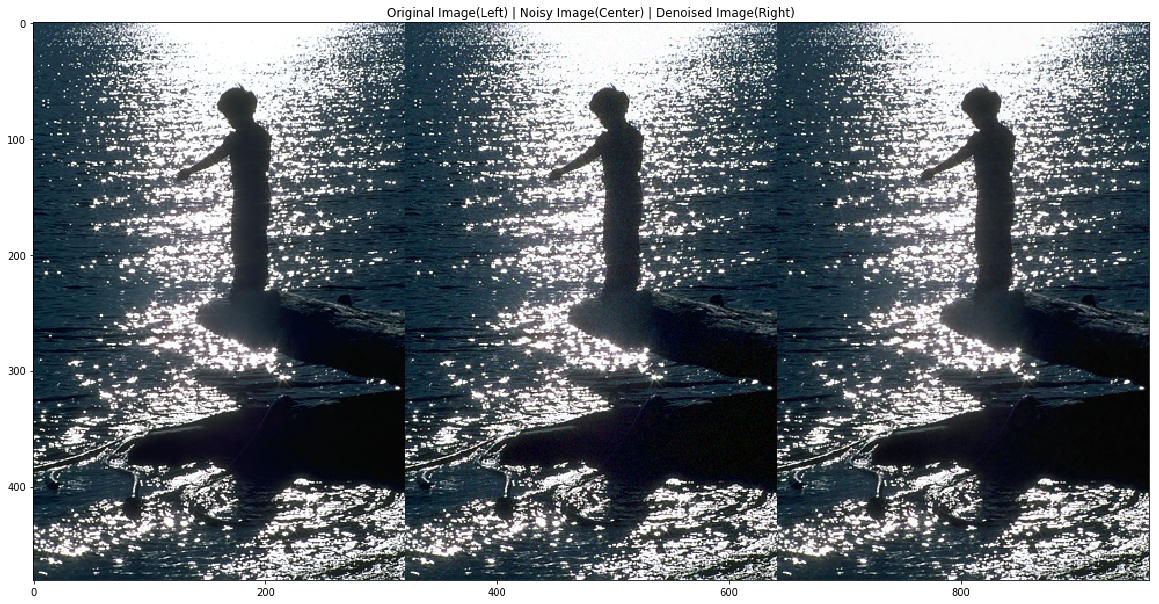

PSNR: 37.849210
 IQI: 0.998842
 SSIM: 0.940157



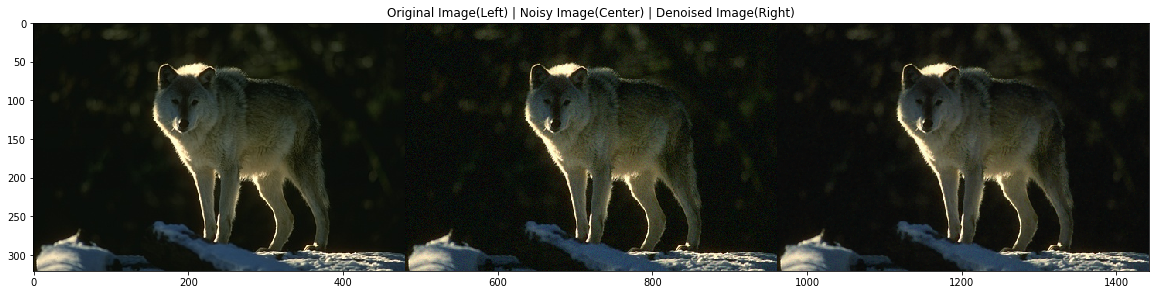

Test Image RMSE: 8.128772 
Unseen Image RMSE: 5.631268
Test Image Estimated Noise: [0.018464471437603762, 0.019365502943310953, 0.019832714173727183]
Unseen Image Estimated Noise: [0.020742786688092853, 0.021278242040911576, 0.020757511246657177]


In [44]:
compare_results(tools.selBest(pop, k=1)[0])